In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
import os
import zipfile
from PIL import Image
import cv2
import numpy
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader,Dataset,ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as Optim

%matplotlib inline

In [3]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [4]:
local_zip_train = '/kaggle/input/dogs-vs-cats/train.zip'
zip_ref = zipfile.ZipFile(local_zip_train, 'r')
zip_ref.extractall('/kaggle/working')
zip_ref.close()

In [5]:
train_dir = '/kaggle/working/train'
train_files = os.listdir(train_dir)
print(len(train_files))

25000


In [6]:
class CatsDogsDataset(Dataset):
    
    def __init__(self,train_files,train_dir,mode="train",transform=None):
        
        self.train_files = train_files
        self.train_dir = train_dir
        self.mode = mode
        self.transform = transform
        
        if mode == "train" or mode == "val":
            if "dog" in self.train_files[0]:
                self.label = 1
            else:
                self.label = 0
    
    def __len__(self):
        return len(self.train_files)
    
    def __getitem__(self,idx):
        image = Image.open(os.path.join(self.train_dir,self.train_files[idx]))
        
        if self.transform:
            img = self.transform(image)
        
        if self.mode == "train" or self.mode == "val":
            img = img.numpy()
            return img.astype('float32'),self.label
        else:
            img = img.numpy()
            return img.astype('float32'),self.train_files[idx]
    

data_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.ColorJitter(),
                                     transforms.RandomCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor()])

cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

cats = CatsDogsDataset(cat_files, train_dir, transform = data_transform)
dogs = CatsDogsDataset(dog_files, train_dir, transform = data_transform)

catdogs = ConcatDataset([cats, dogs])

validation_split = .2
shuffle_dataset = True

dataset_size = len(catdogs)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

trainloader = DataLoader(catdogs, batch_size = 32,num_workers=2,sampler = train_sampler)
valloader = DataLoader(catdogs, batch_size = 32,num_workers=2,sampler = valid_sampler)

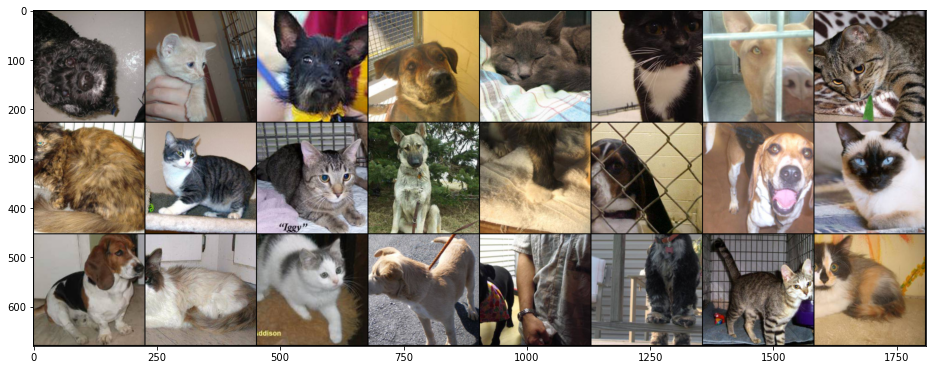

In [7]:
samples, labels = iter(trainloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

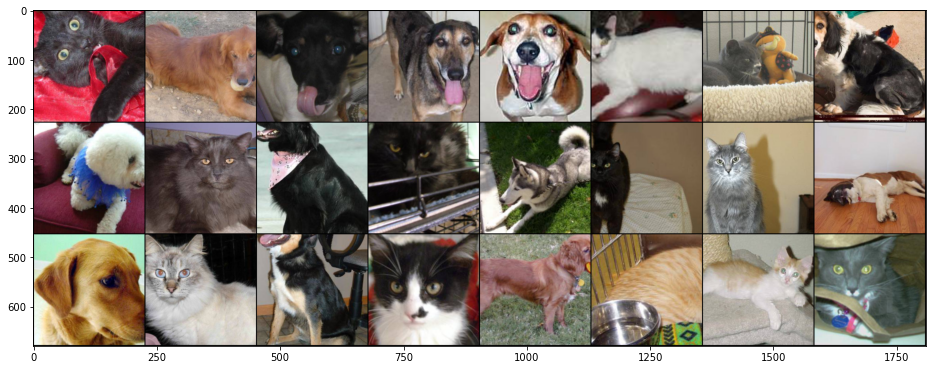

In [8]:
samples, labels = iter(valloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [9]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU


In [12]:
from torchvision import models

resnet50_backbone = models.resnet50(pretrained=True)
resnet50_backbone = resnet50_backbone.to(device)

for param in resnet50_backbone.parameters():
      param.requires_grad = False

        
print(resnet50_backbone)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
from torchsummary import summary
summary(resnet50_backbone, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [22]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.features = nn.Sequential(*(list(resnet50_backbone.children())[:-2])) 
        
        self.conv1 = nn.Conv2d(2048,2048,3,1,1)
        
        self.pool = nn.MaxPool2d(2,2)
        self.batch = nn.BatchNorm2d(2048)
        
        self.drop1 = nn.Dropout(0.3)
        self.drop2 = nn.Dropout(0.2)
        self.drop3 = nn.Dropout(0.1)
        
        self.fc1 = nn.Linear(3*3*2048,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,256)
        self.fc4 = nn.Linear(256,128)
        self.fc5 = nn.Linear(128,32)
        self.fc6 = nn.Linear(32,1)
    
    def forward(self,x):
        
        x = self.features(x)
        
        x = F.relu(self.batch(self.conv1(x)))
        x = self.pool(x)
        
        x = x.view(x.shape[0],x.shape[1]*x.shape[2]*x.shape[3])
        
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        
        x = F.relu(self.fc2(x))
        x = self.drop1(x)
        
        x = F.relu(self.fc3(x))
        x = self.drop2(x)
        
        x = F.relu(self.fc4(x))
        x = self.drop2(x)
        
        x = F.relu(self.fc5(x))
        x = self.drop3(x)
        
        x = torch.sigmoid(self.fc6(x))
        
        return x

net = Net()
net.to(device)
print(net)

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [23]:
summary(net, (3, 224, 224))

torch.Size([2, 2048, 3, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      Batch

In [24]:
criterion = nn.BCELoss()
optimizer = Optim.Adam(net.parameters(),lr = 0.001,weight_decay=1e-5)

In [25]:
def model_eval(dataloader):
    total = 0
    correct = 0
    
    for data in dataloader:
      images, l = data
      images = images.to(device)
      l = l.to(device)
      l=l.reshape(l.shape[0],1)

      out = net(images)
      preds = (out > 0.5)*1
      total += l.shape[0]  
      correct += (preds == l).sum().item()  
    
    accuracy = (100 * correct)/total
    
    
    return accuracy

In [26]:
epochs = 10

for epoch in range(epochs):
    print("Epoch:",epoch)
    
    running_loss = 0.0
    train_loss = 0.0
    I = 0
    for i,data in enumerate(trainloader,0):
        images,labels = data
        images = images.to(device)
        labels = labels.to(device,dtype=torch.float)
        labels = labels.reshape(labels.shape[0],1)
        
        optimizer.zero_grad()
        
        outputs = net(images)
        loss = criterion(outputs,labels)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_loss += loss.item()
        I += i
        
        if i%100 == 99:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    train_loss = train_loss / I
    train_acc = model_eval(trainloader)
    val_acc = model_eval(valloader)
    
    print("Train Loss:",train_loss)
    print("Training Accuracy:",train_acc,"Val Accuracy:",val_acc)
    print("")
    train_loss = 0
    I = 0

Epoch: 0
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])
torch.Size([32, 2048, 3, 3])


KeyboardInterrupt: 